In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd gdrive/

/content/gdrive


In [3]:
cd 'My Drive'/

/content/gdrive/My Drive


In [4]:
cd semantic_segmentation/

/content/gdrive/My Drive/semantic_segmentation


In [0]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision import utils
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.modules.loss import CrossEntropyLoss

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("Running on cpu")

Tesla P4


In [16]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        #ENCODER
        
        self.convE1 = nn.Conv2d(1, 64, kernel_size = (3, 3), stride = 1, padding = 1)#512x512
        self.convE2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = 1, padding = 1)#512x512
        self.convE3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 1, padding = 1)#256x256
        self.convE4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)#256x256
        self.convE5 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = 1, padding = 1)#128x128
        self.convE6 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = 1, padding = 1)#128x128
        self.convE7 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = 1, padding = 1)#64x64
        self.convE8 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = 1, padding = 1)#64x64
        self.convE9 = nn.Conv2d(512, 1024, kernel_size = (3, 3), stride = 1, padding = 1)#32x32
        self.convE10 = nn.Conv2d(1024, 1024, kernel_size = (3, 3), stride = 1, padding = 1)#32x32
        
        #DECODER
        
        self.convT1 = nn.ConvTranspose2d(1024, 512, kernel_size = (4, 4), stride = 2, padding = 1)#64x64
        #concat
        self.convD1 = nn.Conv2d(1024, 512, kernel_size = (3, 3), stride = 1, padding = 1)#64x64
        self.convD2 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = 1, padding = 1)#64x64
        
        self.convT2 = nn.ConvTranspose2d(512, 256, kernel_size = (4, 4), stride = 2, padding = 1)#128x128
        #concat
        self.convD3 = nn.Conv2d(512, 256, kernel_size = (3, 3), stride = 1, padding = 1)#128x128
        self.convD4 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = 1, padding = 1)#128x128
        
        self.convT3 = nn.ConvTranspose2d(256, 128, kernel_size = (4, 4), stride = 2, padding = 1)#256x256
        #concat
        self.convD5 = nn.Conv2d(256, 128, kernel_size = (3, 3), stride = 1, padding = 1)#256x256
        self.convD6 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = 1, padding = 1)#256x256
        
        self.convT4 = nn.ConvTranspose2d(128, 64, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.convD7 = nn.Conv2d(128, 64, kernel_size = (3, 3), stride = 1, padding = 1)#512x512
        self.convD8 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = 1, padding = 1)#512x512
        self.convD9 = nn.Conv2d(64, 2, kernel_size = (3, 3), stride = 1, padding = 1)#512x512
        
        
    def forward(self, x):
        
        #ENCODER
        
        x1 = F.leaky_relu(self.convE1(x))
        x1_concat = F.leaky_relu(self.convE2(x1))
        
        x2 = F.max_pool2d(x1_concat, kernel_size = (2, 2), stride = 2, padding = 0)#256x256
        x2 = F.leaky_relu(self.convE3(x2))
        x2_concat = F.leaky_relu(self.convE4(x2))
        
        x3 = F.max_pool2d(x2_concat, kernel_size = (2, 2), stride = 2, padding = 0)#128x128
        x3 = F.leaky_relu(self.convE5(x3))
        x3_concat = F.leaky_relu(self.convE6(x3))
        
        x4 = F.max_pool2d(x3_concat, kernel_size = (2, 2), stride = 2, padding = 0)#64x64
        x4 = F.leaky_relu(self.convE7(x4))
        x4_concat = F.leaky_relu(self.convE8(x4))
        
        x5 = F.max_pool2d(x4_concat, kernel_size = (2, 2), stride = 2, padding = 0)#32x32
        x5 = F.leaky_relu(self.convE9(x5))
        x5 = F.leaky_relu(self.convE10(x5))
        
        #DECODER
        
        x5 = self.convT1(x5)
        x5 = torch.cat((x5, x4_concat), 1)
        x5 = F.leaky_relu(self.convD1(x5))
        x5 = F.leaky_relu(self.convD2(x5))
        
        x5 = self.convT2(x5)
        x5 = torch.cat((x5, x3_concat), 1)
        x5 = F.leaky_relu(self.convD3(x5))
        x5 = F.leaky_relu(self.convD4(x5))
        
        x5 = self.convT3(x5)
        x5 = torch.cat((x5, x2_concat), 1)
        x5 = F.leaky_relu(self.convD5(x5))
        x5 = F.leaky_relu(self.convD6(x5))
        
        x5 = self.convT4(x5)
        x5 = torch.cat((x5, x1_concat), 1)
        x5 = F.leaky_relu(self.convD7(x5))
        x5 = F.leaky_relu(self.convD8(x5))
        pred = (self.convD9(x5))
        softmax_output = F.log_softmax(pred, dim=2)
        return pred, softmax_output

unet = UNet()
unet.to(device)

UNet(
  (convE1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convE10): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convT1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (convD1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convD2): Conv2d(512, 5

In [0]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr = 0.0002)

In [0]:
path_s = '/content/gdrive/My Drive/semantic_segmentation/data/segmented'
path_o = '/content/gdrive/My Drive/semantic_segmentation/data/original'
for root, dirs, files in os.walk(path_s):
    segmented = sorted(files)
for root, dirs, files in os.walk(path_o):
    original = sorted(files)
    
n = len(original)

In [22]:
EPOCHS = 50
for epoch in range(EPOCHS):
    for i in tqdm(range(n)):
        unet.zero_grad()
        
        
        ori = cv2.imread(os.path.join(path_o, original[i]), 0)
        ori_transformed = cv2.resize(ori, (128,128), interpolation = cv2.INTER_NEAREST)#ori_resized
        #ori_transformed = torch.tensor(np.transpose(ori_resized, (2,0,1))/255.0)
        pred, softmax_output = unet.forward(torch.tensor(np.reshape(ori_transformed/255.0, (1,1, 128, 128)), dtype=torch.float, requires_grad = True).to(device))#ori_transformed[0]
        
        
        
        #background 0 roads 1
        seg = cv2.imread(os.path.join(path_s, segmented[i]))
        seg_resized = cv2.resize(seg, (128,128), interpolation = cv2.INTER_NEAREST)
        seg_transformed = torch.tensor(np.transpose(seg_resized, (2,0,1))).to(device)
        labels = torch.zeros([1, 2, 128, 128], dtype=torch.float).to(device)
        l = seg_transformed[1] / 255
        where_0 = np.where(l.cpu().detach().numpy() == 0)
        where_1 = np.where(l.cpu().detach().numpy() == 1)
        l[where_0] = 1
        l[where_1] = 0
        #background
        labels[0][0] = 1 - l
        #foreground
        labels[0][1] = l
        
        

        loss = criterion(softmax_output, labels)
        loss.backward()
        optimizer.step()
    print('EPOCH = ' + str(epoch) + ' loss = '+str(loss.cpu().detach().numpy()))

  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 0 loss = 28.892178


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 1 loss = 28.891634


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 2 loss = 28.891562


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 3 loss = 28.89132


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 4 loss = 28.89125


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 5 loss = 28.891182


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 6 loss = 28.89086


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 7 loss = 28.890839


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 8 loss = 28.890633


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 9 loss = 28.890596


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 10 loss = 28.890366


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 11 loss = 28.890182


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 12 loss = 28.89013


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 13 loss = 28.889832


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 14 loss = 28.889744


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 15 loss = 28.889643


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 16 loss = 28.889442


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 17 loss = 28.889338


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 18 loss = 28.889257


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 19 loss = 28.889042


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 20 loss = 28.888964


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 21 loss = 28.888788


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 22 loss = 28.888783


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 23 loss = 28.88863


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 24 loss = 28.888422


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 25 loss = 28.888208


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 26 loss = 28.888264


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 27 loss = 28.888199


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 28 loss = 28.887877


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 29 loss = 28.888096


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 30 loss = 28.887966


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 31 loss = 28.888


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 32 loss = 28.887585


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 33 loss = 28.887432


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 34 loss = 28.887371


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 35 loss = 28.887236


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 36 loss = 28.886986


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 37 loss = 28.886806


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 38 loss = 28.886635


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 39 loss = 28.886585


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 40 loss = 28.886345


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 41 loss = 28.886246


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 42 loss = 28.886196


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 43 loss = 28.88636


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 44 loss = 28.886099


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 45 loss = 28.88619


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 46 loss = 28.88602


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 47 loss = 28.885904


  0%|          | 0/19 [00:00<?, ?it/s]

EPOCH = 48 loss = 28.885527


100%|██████████| 19/19 [00:04<00:00,  4.70it/s]

EPOCH = 49 loss = 28.88528


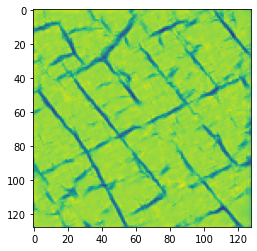

In [27]:
test = cv2.imread('/content/gdrive/My Drive/semantic_segmentation/data/20.tif', 0)
test_transformed = cv2.resize(test, (128,128), interpolation = cv2.INTER_NEAREST)
test_seg = cv2.imread('/content/gdrive/My Drive/semantic_segmentation/data/20.png', 0)
test_pred, test_softmax_output = unet.forward(torch.tensor(np.reshape(test_transformed/255.0, (1,1, 128, 128)), dtype=torch.float, requires_grad = True).to(device))
plt.imshow(test_pred.cpu().detach().numpy()[0][0])

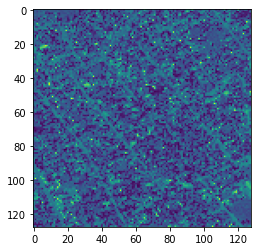

In [26]:
plt.imshow(test_transformed)

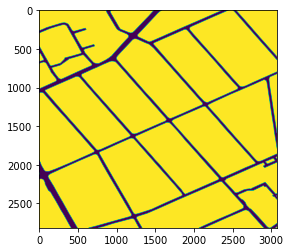

In [28]:
plt.imshow(test_seg)